/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


      market         idt  maturity_target        mu        sd      skew  \
20.0    gold  11/30/2010              6.0 -0.004180  0.158656 -0.026317   
42.0    gold  12/31/2010              6.0 -0.007900  0.151088  0.008910   
62.0    gold  01/31/2011              6.0 -0.007914  0.141959 -0.208558   
81.0    gold  02/28/2011              6.0 -0.009909  0.133097 -0.063939   
104.0   gold  03/31/2011              6.0 -0.007174  0.122637 -0.010455   

           kurt       p10       p50       p90  ...     prInc  label_mbp  \
20.0   0.729372 -0.199223 -0.003858  0.190148  ...  0.090527         -1   
42.0   0.456643 -0.197431 -0.007990  0.179623  ...  0.079967         -1   
62.0   0.520444 -0.190064 -0.002252  0.163424  ...  0.061770         -1   
81.0   0.758719 -0.175255 -0.007949  0.151045  ...  0.053373         -1   
104.0  0.591426 -0.160018 -0.006777  0.143193  ...  0.045164         -1   

       reversal_mbp       Date         Open         High          Low  \
20.0          False 2010-

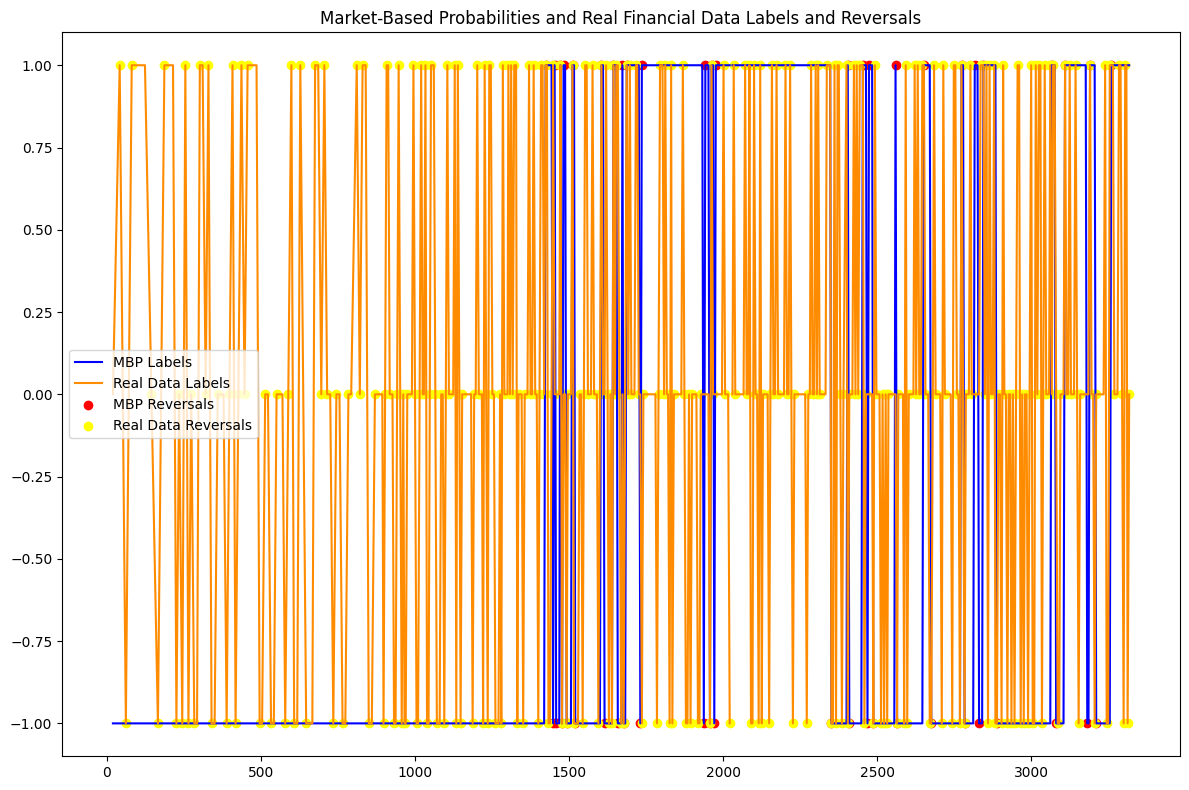

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Load the Excel file
df = pd.read_excel(r"/content/gold.xlsx")

# Assuming prInc and prDec are columns in the same sheet as idt
# Calculate labels for Market-Based Probabilities
df['label_mbp'] = df.apply(lambda row: -1 if row['prDec'] > row['prInc'] else 1, axis=1)

# Identify reversal points for Market-Based Probabilities
df['reversal_mbp'] = df['label_mbp'].diff().ne(0) & df['label_mbp'].diff().notna()

# Get the 'idt' column as 'date' and convert it to datetime
df['date'] = pd.to_datetime(df['idt'])
# Ensure the date range includes enough days before the start date to calculate the moving average
start_date = df['date'].min() - pd.Timedelta(days=30)  # Increased padding to account for non-trading days
end_date = df['date'].max() + pd.Timedelta(days=30)
df.set_index('date', inplace=True)

# Fetch real financial data
stock_data = yf.download("GC=F", start=start_date, end=end_date)

# Reset index to merge on date
stock_data.reset_index(inplace=True)

# Perform a left merge
merged_data = pd.merge(df, stock_data, how='left', left_index=True, right_on='Date')

# Inspect the merged data
print(merged_data.head())

# Calculate labels based on price changes with the given threshold
threshold = 0.014

price_changes = merged_data['Close'].pct_change()
merged_data['label_real'] = price_changes.apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else 0))

# Identify reversal points for real financial data
merged_data['reversal_real'] = merged_data['label_real'].diff().ne(0) & merged_data['label_real'].diff().notna()

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot Market-Based Probabilities labels and reversals
ax.plot(merged_data.index, merged_data['label_mbp'], label='MBP Labels', color='blue')
# Plot real financial data labels and reversals
ax.plot(merged_data.index, merged_data['label_real'], label='Real Data Labels', color='darkorange')
ax.scatter(merged_data.index[merged_data['reversal_mbp']], merged_data['label_mbp'][merged_data['reversal_mbp']], color='red', label='MBP Reversals')
ax.scatter(merged_data.index[merged_data['reversal_real']], merged_data['label_real'][merged_data['reversal_real']], color='yellow', label='Real Data Reversals')
ax.set_title('Market-Based Probabilities and Real Financial Data Labels and Reversals')
ax.legend()

plt.tight_layout()
plt.show()